In [1]:
# utilities
import re
import numpy as np
import pandas as pd
import string
import nltk
# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import RegexpTokenizer
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
#keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Flatten
from keras.layers import Embedding
from keras.preprocessing import sequence

2024-11-07 17:39:03.439263: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-07 17:39:03.442274: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-07 17:39:03.451306: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731026343.467438   96013 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731026343.471942   96013 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-07 17:39:03.486904: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

# Data Acquisition

In [2]:
# Importing the dataset
DATASET_COLUMNS=['target','ids','date','flag','user','text']
DATASET_ENCODING = "ISO-8859-1"
df = pd.read_csv('archive/training.1600000.processed.noemoticon.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
df.sample(5)

,target,ids,date,flag,user,text
127787,0,1834788334,Mon May 18 04:12:17 PDT 2009,NO_QUERY,lisy16,. what's everyones up to? really tired! watchi...
1016592,4,1881725718,Fri May 22 05:24:42 PDT 2009,NO_QUERY,mistressmayhem,@berettablue Hey there!
981566,4,1834124609,Mon May 18 01:43:23 PDT 2009,NO_QUERY,sloti,"@ansi I know it is evil, but I am so weak"
106064,0,1823381547,Sat May 16 21:49:21 PDT 2009,NO_QUERY,laurenATLx3,haha I'm bored too it sucks
117496,0,1827652717,Sun May 17 11:09:49 PDT 2009,NO_QUERY,nessadolly,gaining weight is super hard


In [3]:
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
df. shape

(1600000, 6)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


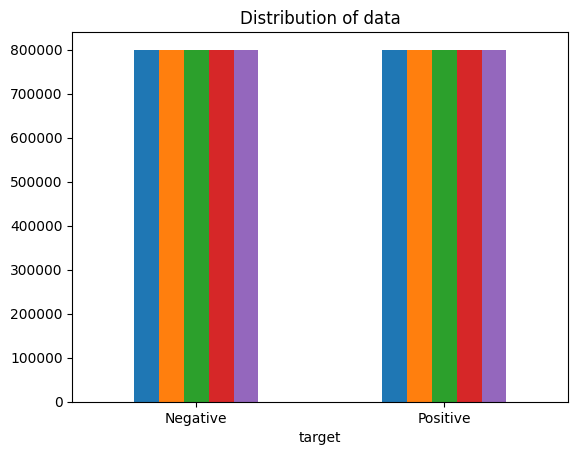

In [6]:
# Plotting the distribution for dataset.
ax = df.groupby('target').count().plot(kind='bar', title='Distribution of data',legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)
# Storing data in lists.
text, sentiment = list(df['text']), list(df['target'])

<Axes: xlabel='target', ylabel='count'>

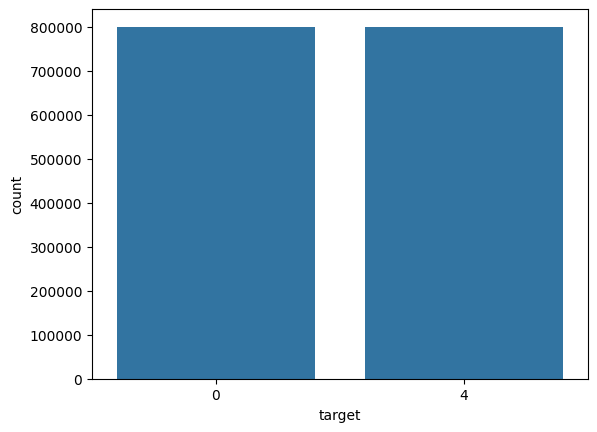

In [7]:
sns.countplot(x='target', data=df)

In [8]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/mathsu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/mathsu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Text Cleanup

In [9]:
data=df[['text','target']]

In [10]:
data_pos = data[data['target'] == 4]
data_neg = data[data['target'] == 0]

In [11]:
dataset = pd.concat([data_pos, data_neg])
dataset.head()

,text,target
800000,I LOVE @Health4UandPets u guys r the best!!,4
800001,im meeting up with one of my besties tonight! ...,4
800002,"@DaRealSunisaKim Thanks for the Twitter add, S...",4
800003,Being sick can be really cheap when it hurts t...,4
800004,@LovesBrooklyn2 he has that effect on everyone,4


In [12]:
#making the text lowercase
dataset['text']=dataset['text'].str.lower()
dataset['text'].tail()

799995    sick  spending my day laying in bed listening ...
799996                                      gmail is down? 
799997                        rest in peace farrah! so sad 
799998    @eric_urbane sounds like a rival is flagging y...
799999    has to resit exams over summer...  wishes he w...
Name: text, dtype: object

In [13]:
# Removing the usernamesd
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt) 
    return input_txt
dataset['text'] = np.vectorize(remove_pattern)(dataset['text'], r'@[A-Za-z0-9]+')

In [14]:
dataset['text'].tail()

799995    sick  spending my day laying in bed listening to 
799996                                      gmail is down? 
799997                        rest in peace farrah! so sad 
799998    _urbane sounds like a rival is flagging your a...
799999    has to resit exams over summer...  wishes he w...
Name: text, dtype: object

In [15]:
#Removing punctuations
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
dataset['text']= dataset['text'].apply(lambda x: cleaning_punctuations(x))
dataset['text'].tail()

799995    sick  spending my day laying in bed listening to 
799996                                       gmail is down 
799997                         rest in peace farrah so sad 
799998    urbane sounds like a rival is flagging your ad...
799999    has to resit exams over summer  wishes he work...
Name: text, dtype: object

# Pre-Processing

In [16]:
# Removing URLs
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_URLs(x))
dataset['text'].tail()

799995    sick  spending my day laying in bed listening to 
799996                                       gmail is down 
799997                         rest in peace farrah so sad 
799998    urbane sounds like a rival is flagging your ad...
799999    has to resit exams over summer  wishes he work...
Name: text, dtype: object

In [17]:
# Removing Numbers
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_numbers(x))
dataset['text'].tail()

799995    sick  spending my day laying in bed listening to 
799996                                       gmail is down 
799997                         rest in peace farrah so sad 
799998    urbane sounds like a rival is flagging your ad...
799999    has to resit exams over summer  wishes he work...
Name: text, dtype: object

In [18]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1600000 entries, 800000 to 799999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   text    1600000 non-null  object
 1   target  1600000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 36.6+ MB


In [19]:
dataset.head()

,text,target
800000,i love u guys r the best,4
800001,im meeting up with one of my besties tonight c...,4
800002,thanks for the twitter add sunisa i got to me...,4
800003,being sick can be really cheap when it hurts t...,4
800004,he has that effect on everyone,4


# Visualization

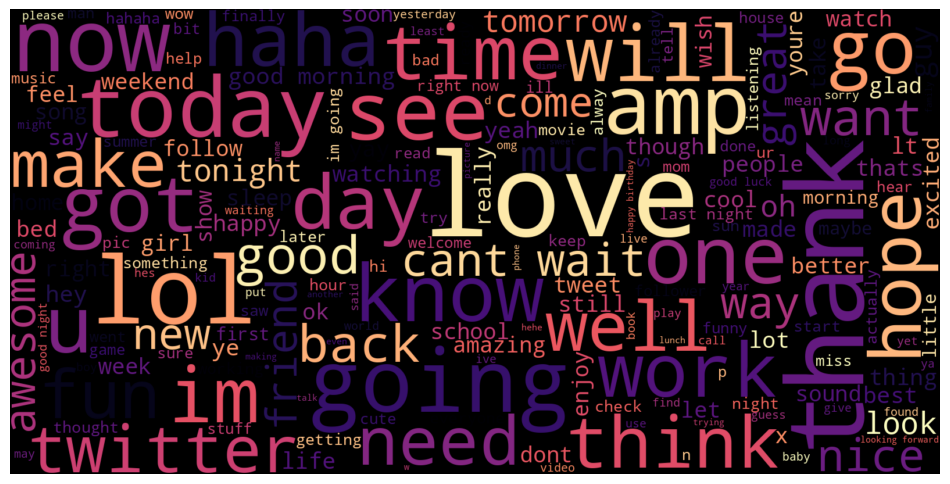

In [20]:
pos_tweets = dataset[dataset.target == 4]
pos_string = []
for t in pos_tweets.text:
    pos_string.append(t)
pos_string = pd.Series(pos_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap='magma').generate(pos_string) 
plt.figure(figsize=(12,10)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.show()

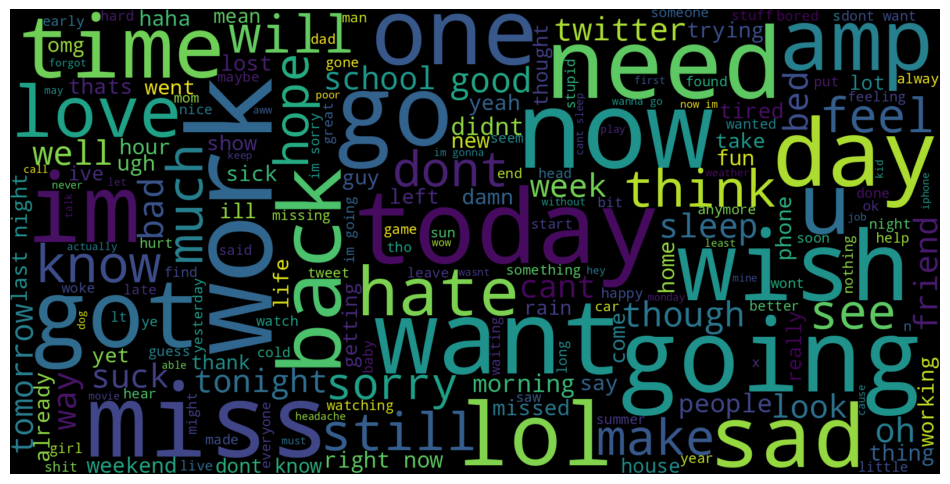

In [21]:
neg_tweets = dataset[dataset.target == 0]
neg_string = []
for t in neg_tweets.text:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [22]:
cvec = CountVectorizer()
cvec.fit(dataset.text)
neg_doc_matrix = cvec.transform(dataset[dataset.target == 0].text)
pos_doc_matrix = cvec.transform(dataset[dataset.target == 4].text)
neg_tf = np.sum(neg_doc_matrix,axis=0)
pos_tf = np.sum(pos_doc_matrix,axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))
term_freq_df = pd.DataFrame([neg,pos],columns=cvec.get_feature_names_out()).transpose()

In [23]:
term_freq_df.head()

,0,1
aa,183,99
aaa,111,60
aaaa,51,35
aaaaa,25,11
aaaaaa,17,12


In [24]:
term_freq_df.columns = ['negative', 'positive']
term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['positive']
term_freq_df.sort_values(by='total', ascending=False).iloc[:10]

,negative,positive,total
to,312172,251698,563870
the,255892,262090,517982
my,188739,124826,313565
and,150999,147057,298056
you,93585,172471,266056
is,127352,108194,235546
it,118742,111745,230487
for,98596,116866,215462
in,114307,99892,214199
of,92500,90826,183326


# More Pre-Processing

In [25]:
# Stemming and Lemmatization
stemmer = nltk.PorterStemmer()
tokenizer = RegexpTokenizer(r'\w+')
def stemming_on_text(sentence):
    words = tokenizer.tokenize(sentence)
    stemmed_words = [stemmer.stem(word) for word in words]
    data = ' '.join(stemmed_words)
    return data
dataset['text']= dataset['text'].apply(lambda x: stemming_on_text(x))
dataset['text'].head()

800000                              i love u guy r the best
800001    im meet up with one of my besti tonight cant w...
800002    thank for the twitter add sunisa i got to meet...
800003    be sick can be realli cheap when it hurt too m...
800004                         he ha that effect on everyon
Name: text, dtype: object

In [26]:
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(sentence):
    words = tokenizer.tokenize(sentence)
    lemma_words = [lm.lemmatize(word) for word in words]
    data = ' '.join(lemma_words)
    return data
dataset['text'] = dataset['text'].apply(lambda x: lemmatizer_on_text(x))
dataset['text'].head()

800000                              i love u guy r the best
800001    im meet up with one of my besti tonight cant w...
800002    thank for the twitter add sunisa i got to meet...
800003    be sick can be realli cheap when it hurt too m...
800004                         he ha that effect on everyon
Name: text, dtype: object

In [27]:
#Train Test Split
x = dataset.text
y = dataset.target
SEED = 2000
x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(x, y, test_size=.02, random_state=SEED)
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED)
print("Train set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_train),
                                                                                         (len(x_train[y_train == 0]) / (len(x_train)*1.))*100,
                                                                                         (len(x_train[y_train == 4]) / (len(x_train)*1.))*100))
print("Validation set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_validation),                                                                          
                                                                                              (len(x_validation[y_validation == 0]) / (len(x_validation)*1.))*100,                                                                       
                                                                                              (len(x_validation[y_validation == 4]) / (len(x_validation)*1.))*100))
print("Test set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_test),                                                          
                                                                                        (len(x_test[y_test == 0]) / (len(x_test)*1.))*100,                                                           
                                                                                        (len(x_test[y_test == 4]) / (len(x_test)*1.))*100))

Train set has total 1568000 entries with 50.01% negative, 49.99% positive
Validation set has total 16000 entries with 49.33% negative, 50.68% positive
Test set has total 16000 entries with 49.45% negative, 50.55% positive


# Feature Engineering

In [25]:
# function to collect hashtags
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags


HT_regular = hashtag_extract(data['text'][data['target'] == 4])
HT_negative = hashtag_extract(data['text'][data['target'] == 0])

# unnesting list
HT_regular = sum(HT_regular,[])
HT_negative = sum(HT_negative,[])

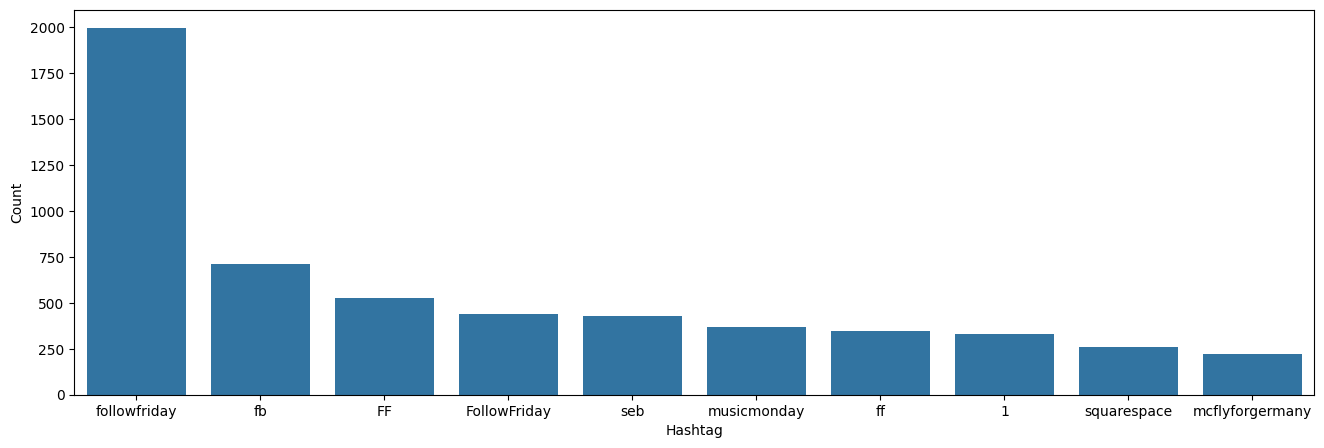

In [26]:
a = nltk.FreqDist(HT_regular)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

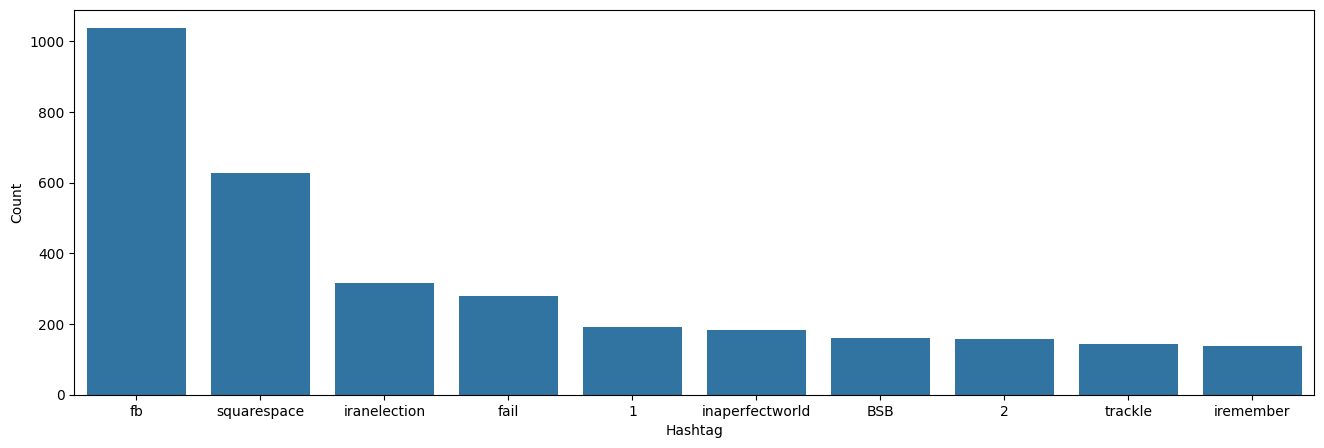

In [27]:
b = nltk.FreqDist(HT_negative)
e = pd.DataFrame({'Hashtag': list(b.keys()), 'Count': list(b.values())})
# selecting top 10 most frequent hashtags
e = e.nlargest(columns="Count", n = 10)   
plt.figure(figsize=(16,5))
ax = sns.barplot(data=e, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

In [28]:
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
# bag-of-words feature matrix
train_bow = bow_vectorizer.fit_transform(x_train)
test_bow = bow_vectorizer.fit_transform(x_test)

In [29]:

lreg = LogisticRegression()
lreg.fit(train_bow, y_train) # training the model

prediction = lreg.predict(test_bow)

f1_score(y_test, prediction, pos_label = 4) # calculating f1 score



np.float64(0.5373687461395923)

In [30]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
train_tfidf = tfidf_vectorizer.fit_transform(x_train)
test_tfidf = tfidf_vectorizer.fit_transform(x_test)
test_tfidf.shape

(16000, 1000)

In [31]:
lreg = LogisticRegression()
lreg.fit(train_tfidf, y_train) # training the model

prediction = lreg.predict(test_tfidf)

f1_score(y_test, prediction, pos_label = 4) # calculating f1 score


np.float64(0.5422063969550003)

# Building the Model

In [32]:
vectoriser = TfidfVectorizer(ngram_range=(1,3), max_features=500000)
vectoriser.fit(x_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))

No. of feature_words:  500000


In [33]:
X_train = vectoriser.transform(x_train)
X_test  = vectoriser.transform(x_test)
X_validation = vectoriser.transform(x_validation)

In [34]:
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
y_pred1 = BNBmodel.predict(X_test)

In [35]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
y_pred2 = SVCmodel.predict(X_test)

In [36]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
y_pred3 = LRmodel.predict(X_test)

In [43]:
# Deep Learning
def batch_generator(X_data, y_data, batch_size):
    samples_per_epoch = X_data.shape[0]
    number_of_batches = samples_per_epoch/batch_size
    counter=0
    index = np.arange(np.shape(y_data)[0])
    while 1:
        index_batch = index[batch_size*counter:batch_size*(counter+1)]
        X_batch = X_data[index_batch,:].toarray()
        y_batch = y_data[y_data.index[index_batch]]
        counter += 1
        yield X_batch,y_batch
        if (counter > number_of_batches):
            counter=0
            
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=500000))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(
    batch_generator(X_train, y_train, 32),  # Pass the generator directly
    epochs=5,
    validation_data=(X_validation, y_validation),  # Provide validation data
    steps_per_epoch=X_train.shape[0] // 32  # Calculate steps per epoch
)


Epoch 1/5
49000/49000 ━━━━━━━━━━━━━━━━━━━━ 14315s 292ms/step - accuracy: 6.5299e-05 - loss: -13822.4385 - val_accuracy: 0.0000e+00 - val_loss: -115255.6172
Epoch 2/5
49000/49000 ━━━━━━━━━━━━━━━━━━━━ 14322s 292ms/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: -433227.4062
Epoch 3/5
10336/49000 ━━━━━━━━━━━━━━━━━━━━ 3:12:06 298ms/step - accuracy: 0.0000e+00 - loss: nan

KeyboardInterrupt: 

In [40]:
# Adding a normalizer
norm = Normalizer().fit(X_train)
x_train_tfidf_norm = norm.transform(X_train)
x_validation_tfidf_norm = norm.transform(X_validation)

In [42]:
# Adding Dropout
model1 = Sequential()
model1.add(Dense(64, activation='relu', input_dim=500000))
model1.add(Dropout(0.2))
model1.add(Dense(1, activation='sigmoid'))
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model1.fit(batch_generator(x_train_tfidf_norm, y_train, 32),
                    epochs=5, validation_data=(x_validation_tfidf_norm, y_validation),
                    steps_per_epoch=x_train_tfidf_norm.shape[0]//32)
y_pred4 = model.predict(X_test)

Epoch 1/5
49000/49000 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 5.0789e-05 - loss: -15643.1240

ValueError: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 1568000
'y' sizes: 16000


In [ ]:
y_pred4

# Evaluation

In [44]:
def model_evaluate(model):
    # Predict values for Test dataset
    y_pred = model.predict(X_test)
    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

              precision    recall  f1-score   support

           0       0.81      0.76      0.78      7912
           4       0.78      0.82      0.80      8088

    accuracy                           0.79     16000
   macro avg       0.79      0.79      0.79     16000
weighted avg       0.79      0.79      0.79     16000



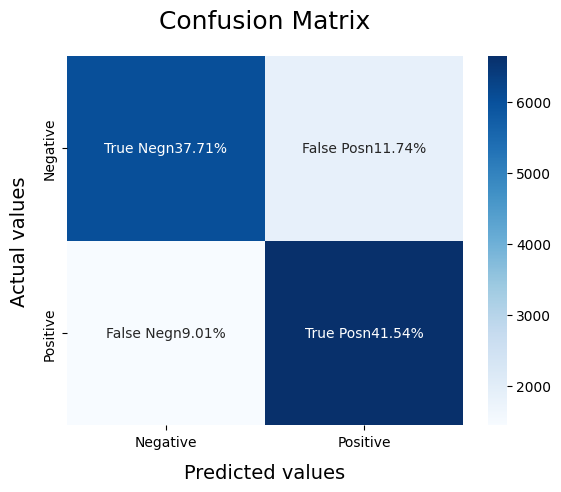

In [45]:
model_evaluate(BNBmodel)

              precision    recall  f1-score   support

           0       0.81      0.81      0.81      7912
           4       0.81      0.82      0.82      8088

    accuracy                           0.81     16000
   macro avg       0.81      0.81      0.81     16000
weighted avg       0.81      0.81      0.81     16000



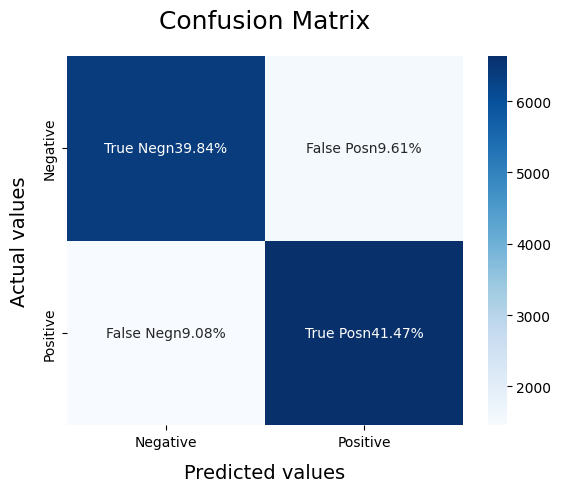

In [46]:
model_evaluate(SVCmodel)

              precision    recall  f1-score   support

           0       0.82      0.81      0.82      7912
           4       0.82      0.83      0.83      8088

    accuracy                           0.82     16000
   macro avg       0.82      0.82      0.82     16000
weighted avg       0.82      0.82      0.82     16000



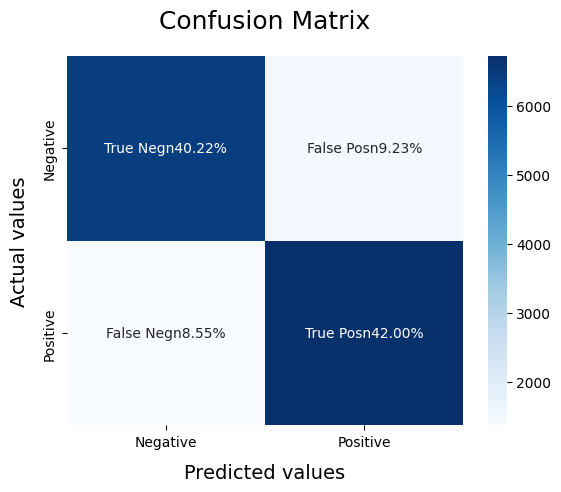

In [47]:
model_evaluate(LRmodel)